In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5658 - acc: 0.3431
Epoch 00001: val_loss improved from inf to 2.19252, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_3_conv_checkpoint/001-2.1925.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 3.5656 - acc: 0.3431 - val_loss: 2.1925 - val_acc: 0.4684
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0146 - acc: 0.5830
Epoch 00002: val_loss did not improve from 2.19252
36805/36805 [==============================] - 59s 2ms/sample - loss: 2.0145 - acc: 0.5830 - val_loss: 2.5331 - val_acc: 0.4701
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5926 - acc: 0.6807
Epoch 00003: val_loss did not improve from 2.19252
36805/36805 [==============================] - 59s 2ms/sample - loss: 1.5924 - acc: 0.6807 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.7479 - acc: 0.9306
Epoch 00029: val_loss did not improve from 2.19252
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.7478 - acc: 0.9306 - val_loss: 3.1060 - val_acc: 0.6231
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7569 - acc: 0.9297
Epoch 00030: val_loss did not improve from 2.19252
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.7568 - acc: 0.9297 - val_loss: 3.0120 - val_acc: 0.6331
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7602 - acc: 0.9292
Epoch 00031: val_loss did not improve from 2.19252
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.7602 - acc: 0.9291 - val_loss: 3.1740 - val_acc: 0.6150
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7412 - acc: 0.9343
Epoch 00032: val_loss did not improve from 2.19252
36805/36805 [========================

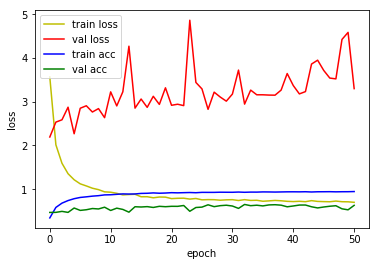

4815/4815 [==============================] - 3s 660us/sample - loss: 2.2415 - acc: 0.4447
Loss: 2.241532568433946 Accuracy: 0.44465214

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3601 - acc: 0.3850
Epoch 00001: val_loss improved from inf to 2.27844, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_4_conv_checkpoint/001-2.2784.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 2.3602 - acc: 0.3850 - val_loss: 2.2784 - val_acc: 0.3988
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4244 - acc: 0.5933
Epoch 00002: val_loss improved from 2.27844 to 1.42281, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_4_conv_checkpoint/002-1.4228.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.4243 - acc: 0.5933 - val_loss: 1.4228 - val_acc: 0.6007
Epoch 3/500
36800/36805 [============================>.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9673
Epoch 00029: val_loss did not improve from 1.30239
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.1101 - acc: 0.9673 - val_loss: 1.8767 - val_acc: 0.7058
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1054 - acc: 0.9678
Epoch 00030: val_loss did not improve from 1.30239
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1054 - acc: 0.9678 - val_loss: 1.8164 - val_acc: 0.7116
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1021 - acc: 0.9690
Epoch 00031: val_loss did not improve from 1.30239
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1021 - acc: 0.9690 - val_loss: 2.3195 - val_acc: 0.6625
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9702
Epoch 00032: val_loss did not improve from 1.30239
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0622 - acc: 0.9835
Epoch 00059: val_loss did not improve from 1.30239
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0622 - acc: 0.9835 - val_loss: 2.5591 - val_acc: 0.6560

1D_CNN_custom_multi_3_concat_DO_BN_4_conv Model


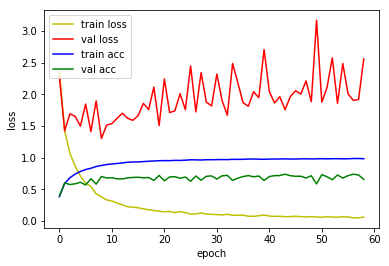

4815/4815 [==============================] - 3s 630us/sample - loss: 1.3796 - acc: 0.6681
Loss: 1.3796283983862412 Accuracy: 0.66812044

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1167 - acc: 0.4002
Epoch 00001: val_loss improved from inf to 1.50457, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_5_conv_checkpoint/001-1.5046.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 2.1166 - acc: 0.4002 - val_loss: 1.5046 - val_acc: 0.5043
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2824 - acc: 0.6165
Epoch 00002: val_loss improved from 1.50457 to 1.09245, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_5_conv_checkpoint/002-1.0925.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.2824 - acc: 0.6164 - val_loss: 1.0925 - val_acc: 0.6692
Epoch 3/500
36800/36805 [============================>

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9523
Epoch 00027: val_loss did not improve from 0.71568
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1443 - acc: 0.9523 - val_loss: 0.7812 - val_acc: 0.8295
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1434 - acc: 0.9533
Epoch 00028: val_loss did not improve from 0.71568
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1433 - acc: 0.9533 - val_loss: 0.7175 - val_acc: 0.8362
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9592
Epoch 00029: val_loss did not improve from 0.71568
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1254 - acc: 0.9592 - val_loss: 0.8479 - val_acc: 0.8137
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9619
Epoch 00030: val_loss did not improve from 0.71568
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9810
Epoch 00057: val_loss did not improve from 0.71568
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0642 - acc: 0.9810 - val_loss: 0.8138 - val_acc: 0.8493
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9800
Epoch 00058: val_loss did not improve from 0.71568
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0656 - acc: 0.9800 - val_loss: 0.8157 - val_acc: 0.8430
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9816
Epoch 00059: val_loss did not improve from 0.71568
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0624 - acc: 0.9816 - val_loss: 0.8141 - val_acc: 0.8512
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9828
Epoch 00060: val_loss did not improve from 0.71568
36805/36805 [===========

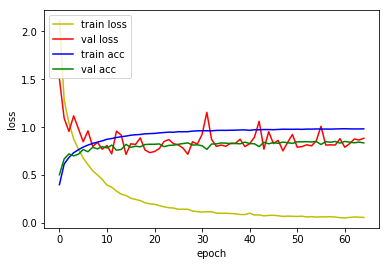

4815/4815 [==============================] - 3s 663us/sample - loss: 0.8304 - acc: 0.7780
Loss: 0.830403923295121 Accuracy: 0.77798545

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0138 - acc: 0.4040
Epoch 00001: val_loss improved from inf to 1.38634, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_6_conv_checkpoint/001-1.3863.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.0137 - acc: 0.4040 - val_loss: 1.3863 - val_acc: 0.5516
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1840 - acc: 0.6370
Epoch 00002: val_loss improved from 1.38634 to 0.88000, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_6_conv_checkpoint/002-0.8800.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.1842 - acc: 0.6370 - val_loss: 0.8800 - val_acc: 0.7419
Epoch 3/500
36800/36805 [============================>.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1434 - acc: 0.9536
Epoch 00025: val_loss did not improve from 0.30893
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1434 - acc: 0.9536 - val_loss: 0.3468 - val_acc: 0.9078
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 - acc: 0.9552
Epoch 00026: val_loss did not improve from 0.30893
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1356 - acc: 0.9551 - val_loss: 0.3355 - val_acc: 0.9110
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1335 - acc: 0.9567
Epoch 00027: val_loss did not improve from 0.30893
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1336 - acc: 0.9567 - val_loss: 0.4043 - val_acc: 0.9019
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1296 - acc: 0.9570
Epoch 00028: val_loss did not improve from 0.30893
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9825
Epoch 00054: val_loss did not improve from 0.30144
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0547 - acc: 0.9825 - val_loss: 0.3053 - val_acc: 0.9350
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9824
Epoch 00055: val_loss did not improve from 0.30144
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0562 - acc: 0.9824 - val_loss: 0.3756 - val_acc: 0.9166
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9829
Epoch 00056: val_loss did not improve from 0.30144
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0509 - acc: 0.9828 - val_loss: 0.3059 - val_acc: 0.9311
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9811
Epoch 00057: val_loss did not improve from 0.30144
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9896
Epoch 00083: val_loss did not improve from 0.29554
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0313 - acc: 0.9896 - val_loss: 0.3167 - val_acc: 0.9378
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9886
Epoch 00084: val_loss did not improve from 0.29554
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0354 - acc: 0.9886 - val_loss: 0.3309 - val_acc: 0.9322
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9902
Epoch 00085: val_loss did not improve from 0.29554
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0313 - acc: 0.9902 - val_loss: 0.3124 - val_acc: 0.9352
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9900
Epoch 00086: val_loss did not improve from 0.29554
36805/36805 [========================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9885
Epoch 00113: val_loss did not improve from 0.29554
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0377 - acc: 0.9885 - val_loss: 0.3364 - val_acc: 0.9364
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9919
Epoch 00114: val_loss did not improve from 0.29554
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0263 - acc: 0.9919 - val_loss: 0.3401 - val_acc: 0.9371

1D_CNN_custom_multi_3_concat_DO_BN_6_conv Model


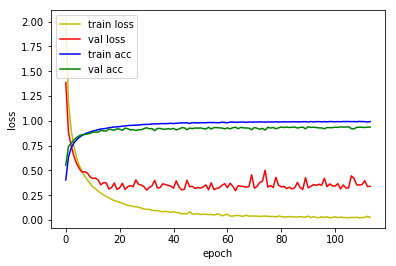

4815/4815 [==============================] - 3s 723us/sample - loss: 0.3692 - acc: 0.9161
Loss: 0.36920918753817444 Accuracy: 0.91609555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0097 - acc: 0.3930
Epoch 00001: val_loss improved from inf to 1.30182, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_7_conv_checkpoint/001-1.3018.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 2.0095 - acc: 0.3930 - val_loss: 1.3018 - val_acc: 0.5742
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0709 - acc: 0.6651
Epoch 00002: val_loss improved from 1.30182 to 0.74630, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_7_conv_checkpoint/002-0.7463.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.0709 - acc: 0.6651 - val_loss: 0.7463 - val_acc: 0.7789
Epoch 3/500
36800/36805 [============================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9719
Epoch 00026: val_loss did not improve from 0.18510
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0861 - acc: 0.9719 - val_loss: 0.1991 - val_acc: 0.9488
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0776 - acc: 0.9744
Epoch 00027: val_loss did not improve from 0.18510
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0780 - acc: 0.9743 - val_loss: 0.2062 - val_acc: 0.9415
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9743
Epoch 00028: val_loss did not improve from 0.18510
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0787 - acc: 0.9742 - val_loss: 0.2303 - val_acc: 0.9429
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0836 - acc: 0.9724
Epoch 00029: val_loss did not improve from 0.18510
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9897
Epoch 00055: val_loss did not improve from 0.18115
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0313 - acc: 0.9897 - val_loss: 0.2234 - val_acc: 0.9513
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9907
Epoch 00056: val_loss did not improve from 0.18115
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0280 - acc: 0.9907 - val_loss: 0.2166 - val_acc: 0.9534
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9910
Epoch 00057: val_loss did not improve from 0.18115
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0292 - acc: 0.9910 - val_loss: 0.2321 - val_acc: 0.9481
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9895
Epoch 00058: val_loss did not improve from 0.18115
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9950
Epoch 00085: val_loss did not improve from 0.18115
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0151 - acc: 0.9950 - val_loss: 0.2297 - val_acc: 0.9567
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9942
Epoch 00086: val_loss did not improve from 0.18115
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0184 - acc: 0.9942 - val_loss: 0.2366 - val_acc: 0.9541
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9916
Epoch 00087: val_loss did not improve from 0.18115
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0254 - acc: 0.9916 - val_loss: 0.2140 - val_acc: 0.9562
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9943
Epoch 00088: val_loss did not improve from 0.18115
36805/36805 [===========

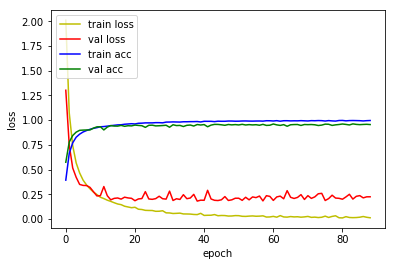

4815/4815 [==============================] - 4s 751us/sample - loss: 0.2417 - acc: 0.9356
Loss: 0.24168295059449824 Accuracy: 0.93561786

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9848 - acc: 0.3995
Epoch 00001: val_loss improved from inf to 1.28477, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_8_conv_checkpoint/001-1.2848.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 1.9849 - acc: 0.3995 - val_loss: 1.2848 - val_acc: 0.5966
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9442 - acc: 0.7020
Epoch 00002: val_loss improved from 1.28477 to 0.54935, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_BN_8_conv_checkpoint/002-0.5494.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.9443 - acc: 0.7019 - val_loss: 0.5494 - val_acc: 0.8470
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0697 - acc: 0.9774
Epoch 00026: val_loss did not improve from 0.13433
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0697 - acc: 0.9774 - val_loss: 0.1556 - val_acc: 0.9550
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9815
Epoch 00027: val_loss did not improve from 0.13433
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0579 - acc: 0.9815 - val_loss: 0.1671 - val_acc: 0.9574
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9748
Epoch 00028: val_loss did not improve from 0.13433
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0793 - acc: 0.9748 - val_loss: 0.1358 - val_acc: 0.9602
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9849
Epoch 00029: val_loss did not improve from 0.13433
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9954
Epoch 00055: val_loss did not improve from 0.13371
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0158 - acc: 0.9954 - val_loss: 0.1869 - val_acc: 0.9560
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9945
Epoch 00056: val_loss did not improve from 0.13371
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0177 - acc: 0.9945 - val_loss: 0.1704 - val_acc: 0.9609
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9938
Epoch 00057: val_loss did not improve from 0.13371
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0208 - acc: 0.9938 - val_loss: 0.2077 - val_acc: 0.9553
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9930
Epoch 00058: val_loss did not improve from 0.13371
36805/36805 [========================

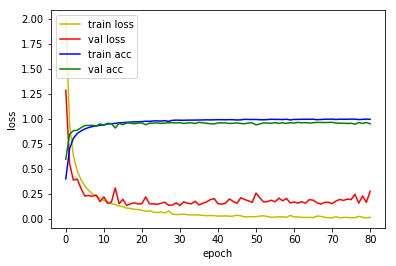

4815/4815 [==============================] - 4s 806us/sample - loss: 0.1895 - acc: 0.9439
Loss: 0.18951877616384566 Accuracy: 0.94392526



In [10]:
base = '1D_CNN_custom_multi_3_concat_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
____________________________________________________________

4815/4815 [==============================] - 4s 816us/sample - loss: 1.3796 - acc: 0.6681
Loss: 1.3796283983862412 Accuracy: 0.66812044

1D_CNN_custom_multi_3_concat_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activati

4815/4815 [==============================] - 4s 840us/sample - loss: 0.3692 - acc: 0.9161
Loss: 0.36920918753817444 Accuracy: 0.91609555

1D_CNN_custom_multi_3_concat_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activat

4815/4815 [==============================] - 4s 912us/sample - loss: 0.1895 - acc: 0.9439
Loss: 0.18951877616384566 Accuracy: 0.94392526


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
____________________________________________________________

4815/4815 [==============================] - 4s 921us/sample - loss: 2.9999 - acc: 0.6075
Loss: 2.9999288387140135 Accuracy: 0.60747665

1D_CNN_custom_multi_3_concat_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activati

4815/4815 [==============================] - 5s 958us/sample - loss: 0.3997 - acc: 0.9227
Loss: 0.39971530357547885 Accuracy: 0.9227414

1D_CNN_custom_multi_3_concat_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3266 - acc: 0.9321
Loss: 0.3265712559037491 Accuracy: 0.93208724
